In [3]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO
import json
import matplotlib.pyplot as plt

In [5]:
with open('../dataset/test.json', 'r') as f:
    test = json.load(f)

pred = pd.read_csv('submission_our_final.csv')

final_annos = []
score_thres = 0.002

for (i, x), t_img in zip(pred.iterrows(), test['images']):

    assert x['image_id'] == t_img['file_name']

    p = list(map(float, x['PredictionString'].split()[1::6]))
    c = list(map(int, x['PredictionString'].split()[::6]))
    x_min = np.array(list(map(float, x['PredictionString'].split()[2::6])))
    y_min = np.array(list(map(float, x['PredictionString'].split()[3::6])))
    w = np.array(list(map(float, x['PredictionString'].split()[4::6]))) - x_min
    h = np.array(list(map(float, x['PredictionString'].split()[5::6]))) - y_min

    new_annos = []

    for p_, c_, x_, y_, w_, h_ in zip(p, c, x_min, y_min, w, h):
        if p_ > score_thres:
            
            new_anno =  {'image_id': t_img['id'],
                          'bbox': [round(x_, 1), round(y_, 1), round(w_, 1), round(h_, 1)],
                          'score': p_,
                          'category_id': c_}
            
            final_annos.append(new_anno)

print(len(final_annos))

with open(f'result_final.json', 'w') as f:
    json.dump(final_annos, f)

555962


In [8]:
with open(f'result_final2.json', 'w') as f:
    json.dump(final_annos, f)

In [ ]:
image_id = train['images'][-1]['id'] + 1
anno_id = train['annotations'][-1]['id'] + 1

score_thres_lo = 0.3
score_thres_hi = 0.3


for (i, x), t_img in zip(pred.iterrows(), test['images']):
    
    assert x['image_id'] == t_img['file_name']
    
    p = list(map(float, x['PredictionString'].split()[1::6]))
    c = list(map(int, x['PredictionString'].split()[::6]))
    x_min = np.array(list(map(float, x['PredictionString'].split()[2::6])))
    y_min = np.array(list(map(float, x['PredictionString'].split()[3::6])))
    w = np.array(list(map(float, x['PredictionString'].split()[4::6]))) - x_min
    h = np.array(list(map(float, x['PredictionString'].split()[5::6]))) - y_min
    
    new_annos = []
    
    for p_, c_, x_, y_, w_, h_ in zip(p, c, x_min, y_min, w, h):
        if p_ > score_thres:
            new_anno =  {'image_id': image_id,
                         'category_id': c_,
                         'area': round(w_*h_, 2),
                         'bbox': [round(x_, 1), round(y_, 1), round(w_, 1), round(h_, 1)],
                         'iscrowd': 0,
                         'id': anno_id}
            new_annos.append(new_anno)
            anno_id += 1
    
    if len(new_annos) != 0:
        t_img['id'] = image_id
        train['images'].append(t_img)
        train['annotations'].extend(new_annos)
        image_id += 1

In [78]:
with open('test_pseudo.json', 'w') as f:
    json.dump(train, f)

In [ ]:
# check

3906
3.801331285202253
1.0
4 0.00021534320323014804


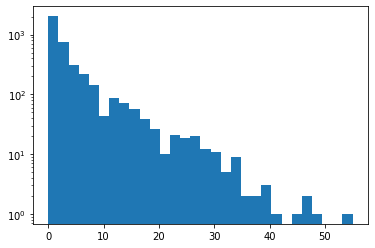

In [4]:
# original annos distribution

cnts = [0]*len(train['images'])
sm = 0
for anno in train['annotations']:
    try:
        cnts[anno['image_id']] += 1
        x,y,w,h = anno['bbox']
        if w*h < 300:
            sm += 1
    except:
        print(anno['image_id'])
        break
        
print(np.mean(cnts))
print(np.median(cnts))
print(sm, sm/len(train['annotations']))

plt.hist(cnts, bins=30, log=True)
plt.show()

In [79]:
coco = COCO('test_pseudo.json')
base_path = '/opt/ml/detection/dataset'

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [84]:
# 이미지 랜덤 추출
imgIds = coco.getImgIds()
img = coco.loadImgs(imgIds[1])[0]
img

{'width': 1024,
 'height': 1024,
 'file_name': 'test/0001.jpg',
 'license': 0,
 'flickr_url': None,
 'coco_url': None,
 'date_captured': '2020-12-27 17:23:39',
 'id': 1}

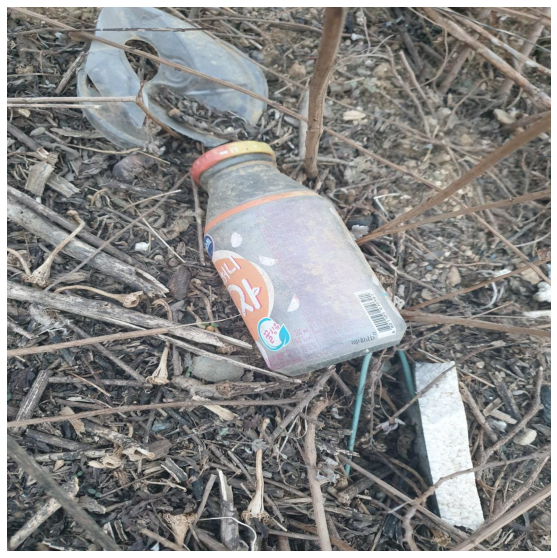

In [85]:
# 이미지 확인
import cv2
import os

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.imread(os.path.join(base_path, img['file_name']))[...,::-1])
plt.show()

In [86]:
# 이미지의 박스는 무엇인가?

annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
print(annIds)
anns = coco.loadAnns(annIds)
print(anns)

[14, 15, 16, 17]
[{'image_id': 1, 'category_id': 6, 'area': 45411.24, 'bbox': [759.6, 663.2, 139.0, 326.6], 'iscrowd': 0, 'id': 14}, {'image_id': 1, 'category_id': 5, 'area': 99570.24, 'bbox': [133.4, 0.1, 360.3, 276.4], 'iscrowd': 0, 'id': 15}, {'image_id': 1, 'category_id': 5, 'area': 183039.23, 'bbox': [344.7, 248.6, 409.9, 446.5], 'iscrowd': 0, 'id': 16}, {'image_id': 1, 'category_id': 4, 'area': 183230.54, 'bbox': [346.4, 246.5, 407.9, 449.2], 'iscrowd': 0, 'id': 17}]


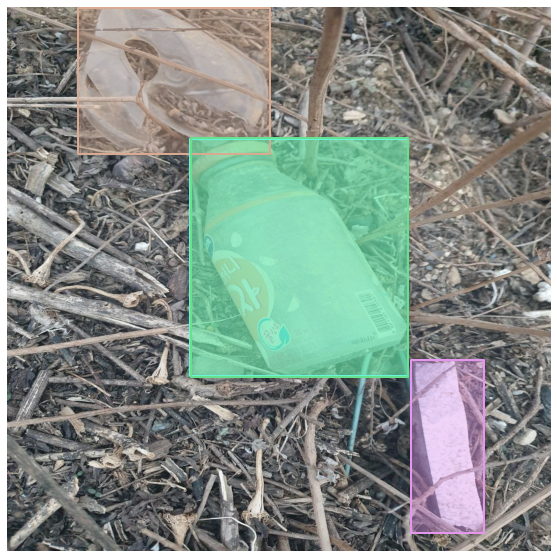

In [87]:
# Box 표시

for d in anns:
    d['segmentation'] = []

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv2.imread(os.path.join(base_path, img['file_name']))[...,::-1])
coco.showAnns(anns, draw_bbox=True)
plt.show()

In [ ]:
pred = pd.read_csv('submission_ensemble_final.csv')

In [ ]:
score_thres = 0.5
tot_img = 0
tot_anno = 0


for i, x, in pred.iterrows():
    
    p = list(map(float, x['PredictionString'].split()[1::6]))
    # c = np.array(list(map(int, x['PredictionString'].split()[::6])))
    # x_min = np.array(list(map(float, x['PredictionString'].split()[2::6])))
    # y_min = np.array(list(map(float, x['PredictionString'].split()[3::6])))
    # w = np.array(list(map(float, x['PredictionString'].split()[4::6]))) - x_min
    # h = np.array(list(map(float, x['PredictionString'].split()[5::6]))) - y_min
    
    flag = False
    
    for p_ in p:
        if p_ > score_thres:
            tot_anno += 1
            flag = True
            
    
    if flag:
        tot_img += 1
    
print(tot_img, tot_anno)
#     anns = np.array(anns)
    
#     if len(anns) !=0 and all(anns > 0.7):
#         confident += 1

#         cnts[i] += len(anns)
    
#     #w = np.array(list(map(float, x['PredictionString'].split()[4::6]))) - np.array(list(map(float, x['PredictionString'].split()[2::6])))
#     #h = np.array(list(map(float, x['PredictionString'].split()[5::6]))) - np.array(list(map(float, x['PredictionString'].split()[3::6])))
    
#     # for p_, w_, h_ in zip(p, w, h):
#     #     tot += 1
#     #     if w_*h_ <= 300:
#     #         cnt += 1
#     #         # if p_ > 0.1:
#     #         #     print(p_, w_*h_)
# # (cnt*100)/tot

# print(np.mean(cnts))
# print(np.median(cnts))
# print(np.sum(cnts != 0))
# print(confident)

# plt.hist(cnts, bins=30, log=True)
# plt.show()

[[ 604.50006  519.0639   955.22052 1023.64185]
 [ 215.84341   51.07205  454.4668   473.92929]
 [ 119.19492  421.47183  330.25491  717.42639]
 ...
 [ 429.708    473.08     587.672    684.162  ]
 [ 420.888    648.278    444.778    670.783  ]
 [ 359.30365  596.60858  416.8764   635.57605]]


In [248]:
prediction_strings = []
file_names = []
iou_thr = 0.6

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=iou_thr, weights=weights)
        labels = labels.astype(np.int32)
        for box, score, label in zip(boxes, scores, labels):
            if score < 0.002:
                continue
            prediction_string += str(label) + ' ' + str(round(score, 5)) + ' ' + str(round(box[0] * image_info['width'], 5)) + ' ' + str(round(box[1] * image_info['height'], 5)) + ' ' + str(round(box[2] * image_info['width'], 5)) + ' ' + str(round(box[3] * image_info['height'], 5)) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.1156455078125, 1.0, 0.354064453125, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.0, 1.0, 0.995859375, 1.0].
  warnings.warn("Zero area box ski

/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.1048330078125, 1.0, 0.206294921875, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))


/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [1.0, 0.526568359375, 1.0, 0.834833984375].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.0, 0.0, 0.0, 0.984033203125].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [1.0, 0.630935546875, 1.0, 0.932857421875].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.1214384765625, 1.0, 0.2430234375, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packa

/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.6797900390625, 1.0, 0.789380859375, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.6140615234375, 1.0, 0.83058203125, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.2144921875, 1.0, 0.262390625, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.262064453125, 1.0, 0.3109248046875, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/s

/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.8570419921875, 1.0, 0.9798642578125, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.0, 1.0, 0.9852529296875, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.0, 1.0, 0.9814267578125, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.176265625, 0.0, 0.5167490234375, 0.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ense

/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.7218154296875, 1.0, 1.0, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.0, 1.0, 0.29062109375, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.723837890625, 1.0, 0.8412871093750001, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [0.1593662109375, 1.0, 0.222849609375, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/opt/conda/envs/mmdetection/lib/python3.8/site-packages/e

In [249]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('submission_ensemble_final.csv')
submission.head()

,PredictionString,image_id
0,7 0.99337 604.50006 519.0639 955.22052 1023.64...,test/0000.jpg
1,6 0.81727 759.64905 663.20923 898.69226 989.80...,test/0001.jpg
2,1 0.91679 297.7955 316.35049 1016.82751 747.00...,test/0002.jpg
3,9 0.94688 152.35065 260.7012 908.34216 814.895...,test/0003.jpg
4,1 0.80184 198.69937 253.43524 871.37543 777.59...,test/0004.jpg


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4871 entries, 0 to 4870
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PredictionString  4871 non-null   object
 1   image_id          4871 non-null   object
dtypes: object(2)
memory usage: 76.2+ KB
